<a href="https://colab.research.google.com/github/computervision-nanodegree/Facial-Keypoints/blob/master/kaggleFaceKeypoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir -p ~/.kaggle
!cp drive/My\ Drive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
!ls -l ~/.kaggle

total 4
-rw------- 1 root root 66 Nov 27 15:11 kaggle.json


In [0]:
!pip install -q kaggle
!pip install -q kaggle-cli
!kaggle competitions download -c facial-keypoints-detection

     |████████████████████████████████| 81kB 2.3MB/s 
     |████████████████████████████████| 5.3MB 8.2MB/s 
     |████████████████████████████████| 112kB 51.5MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 112kB 58.2MB/s 
 85% 51.0M/60.1M [00:00<00:00, 100MB/s] 
100% 60.1M/60.1M [00:00<00:00, 152MB/s]
 56% 9.00M/16.0M [00:00<00:00, 66.0MB/s]
100% 16.0M/16.0M [00:00<00:00, 78.3MB/s]
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 175MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 115MB/s]


In [0]:
!unzip test.zip
!unzip training.zip

Archive:  test.zip
  inflating: test.csv                
Archive:  training.zip
  inflating: training.csv            


In [0]:
import pandas as pd
df= pd.read_csv('training.csv')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head(2)

(2140, 31)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...


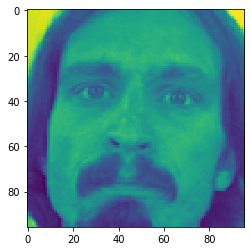

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
image= np.fromstring(df['Image'][0], dtype= int, sep= ' ')
image = np.reshape(image, (96, 96))
plt.imshow(image)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2 as cv
BASEDIR= ''

In [0]:
class KeyPointDataset(Dataset):
    # key point dataset for pytorch
    def __init__(self, csvfile, rootdir, transform= None):
        # get image and keypoints from the dataframe
        self.df= pd.read_csv(csvfile)
        self.df.dropna(inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        self.images= self.df['Image']
        self.keypoints= self.df.drop('Image', axis= 1)
        self.transform= transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image= self.images[idx]
        image= np.fromstring(image, dtype= int, sep= ' ')
        keypoint= self.keypoints
        sample = {}
        sample['image'] = image.reshape(96, 96).astype('float32')
        keypoint = keypoint.iloc[idx].values
        sample['keypoints']= np.array(keypoint).astype('float32')#np.array([i for i in keypoint if np.isnan(i)==False]).reshape(-1, 2)
        
        if self.transform:
            sample= self.transform(sample)
        
        return sample

[[64.33294  34.970078]
 [29.949276 33.448715]]
[[219. 215. 204. ...  92.  88.  84.]
 [222. 219. 220. ...  92.  88.  86.]
 [231. 224. 212. ...  77.  80.  84.]
 ...
 [  1.   1.   1. ...   1.   1.   1.]
 [  1.   1.   1. ...   1.   1.   1.]
 [  1.   1.   1. ...   1.   1.   1.]]
[[65.68337  38.214165]
 [29.471119 38.214165]]
[[ 49.  47.  48. ... 209. 209. 209.]
 [ 47.  49.  50. ... 208. 206. 206.]
 [ 47.  51.  53. ... 209. 207. 206.]
 ...
 [ 84.  92.  92. ... 191. 192. 189.]
 [ 81.  93.  91. ... 190. 191. 191.]
 [ 85.  94.  87. ... 190. 188. 189.]]


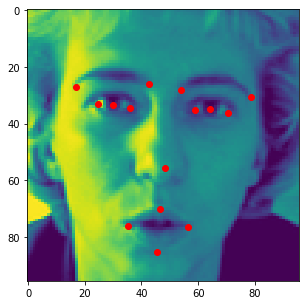

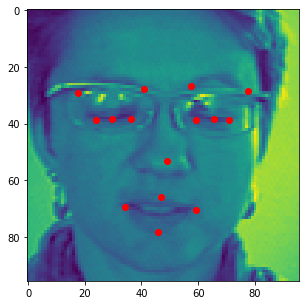

In [0]:
train_set= KeyPointDataset(BASEDIR + 'training.csv', 'training')
def dataViz(dataset, idx):
  plt.figure(figsize= (5, 5))
  image= dataset[idx]['image']
  keypts= dataset[idx]['keypoints'].reshape(-1, 2)
  print(keypts[:2])
  print(image[:, :])
  plt.imshow(image[:, :])
  plt.scatter(keypts[:, 0], keypts[:, 1], c= 'r',)
    
dataViz(train_set, 1)
dataViz(train_set, 210)

In [0]:
# checking GPU details and availability of cuda
print('Cuda Availability : ', torch.cuda.is_available())
!nvidia-smi

Cuda Availability :  True
Wed Nov 27 15:12:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                  

In [0]:
# creating  pytorch model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
class Flatten(torch.nn.Module):
  def forward(self, x):
    batch_size = x.shape[0]
    return x.view(batch_size, -1)


def init_weights(m):
  if type(m) == nn.Linear or type(m) == nn.Conv2d:
    torch.nn.init.kaiming_normal_(m.weight)
    m.bias.data.fill_(0.01)
  

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1= nn.Sequential(
        nn.Conv2d(in_channels= 1, out_channels= 16, kernel_size= 3, padding= 1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout2d(0.5),
        nn.MaxPool2d(kernel_size= 3, stride= 2),
        
        nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= 3, padding= 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout2d(0.5),
        nn.MaxPool2d(kernel_size= 3, stride= 2),

        # nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3, padding= 1),
        # nn.BatchNorm2d(64),
        # nn.ReLU(),
        # nn.Dropout2d(0.5),
        # nn.MaxPool2d(kernel_size= 3, stride= 2),
      )

    # self.conv2= nn.Sequential(
    #     nn.Conv2d(in_channels= 1, out_channels= 16, kernel_size= 5, padding= 1),
    #     nn.BatchNorm2d(16),
    #     nn.ReLU(),
    #     nn.Dropout2d(0.5),
    #     nn.MaxPool2d(kernel_size= 5, stride= 2),
        
    #     nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= 5, padding= 1),
    #     nn.BatchNorm2d(32),
    #     nn.ReLU(),
    #     nn.Dropout2d(0.5),
    #     nn.MaxPool2d(kernel_size= 5, stride= 2),
    #   )

    self.flatten= Flatten()
    
    self.fc1= nn.Sequential(
        nn.Linear(in_features= 16928, out_features= 7744),
        nn.ReLU(),
        nn.Dropout(0.5),
    )
    self.fc2= nn.Sequential(
        nn.Linear(in_features= 7744, out_features= 900),
        nn.ReLU(),
        nn.Dropout(0.5),
    )
    self.fc3= nn.Sequential(
        nn.Linear(in_features= 900, out_features= 30),
        # nn.Softmax()
    )

  def forward(self, t):
    self.conv1.apply(init_weights)
    # self.conv2.apply(init_weights)
    self.fc1.apply(init_weights)
    self.fc2.apply(init_weights)
    # self.fc3.apply(init_weights)

    ta= self.conv1(t)
    # tb= self.conv2(t)
    t2a= self.flatten(ta)
    t3= self.fc1(t2a)
    t4= self.fc2(t3)
    t5= self.fc3(t4)

    return t5

cuda:0


In [0]:
# testing our network instance
print(torch.__version__)
net = Net().to(device)
net

1.3.1


Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.5, inplace=False)
    (9): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten()
  (fc1): Sequential(
    (0): Linear(in_features=16928, out_features=7744, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=7744, out_features=900, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features

In [0]:
# testing our network
# Actual 
class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""
  def __call__(self, sample):
    image, landmarks = sample['image'], sample['keypoints']

    image = image.reshape(1, 96, 96)
    return {'image': torch.from_numpy(image), 'keypoints': torch.from_numpy(landmarks)}

train_set= KeyPointDataset(BASEDIR + 'training.csv', 'training', transform= transforms.Compose([ToTensor()]))    
trainloader= DataLoader(dataset= train_set, batch_size= 1, shuffle= True)
sample= next(iter(trainloader))
image, label= sample['image'], np.array(sample['keypoints']).reshape(-1, 2)

In [0]:
predicted= net(image.to(device))
predicted

tensor([[-2.1283,  1.6100, -0.3580,  1.0375, -2.6626, -4.4186,  1.2104,  0.0312,
          0.8832,  2.3044,  1.9535,  0.4349, -0.1859, -1.6905,  2.3435, -0.6377,
         -1.3346,  2.1753, -3.1847, -1.1359, -3.1988, -1.3074,  0.0369,  2.0217,
         -2.3288, -0.5856, -1.2813,  1.3871, -2.8013, -2.2487]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
sample['keypoints']

tensor([[69.2053, 32.4164, 30.2756, 34.4027, 63.6444, 33.2109, 75.1644, 33.2109,
         37.8231, 34.0054, 25.1111, 35.9920, 56.4933, 22.4852, 81.1236, 22.4852,
         42.5902, 23.6769, 15.5769, 29.6356, 52.9182, 51.0871, 66.4249, 73.3333,
         37.8231, 72.1413, 52.1236, 65.3884, 53.3156, 82.8676]])

In [0]:
# fun part : TRAINING
import torch.optim as optim
optimizer= optim.Adam(net.parameters(), lr= 0.001)

trainset= KeyPointDataset(BASEDIR + 'training.csv', 'training', transform= transforms.Compose([ToTensor()]))    
trainloader= DataLoader(dataset= trainset, batch_size= 535, shuffle= True)
# print(trainloader)
epoch = 1000
for e in range(epoch):
  total_loss= 0

  for batch in trainloader:
    images, labels= batch['image'], batch['keypoints']
    images= images.to(device)
    labels= labels.to(device)

    optimizer.zero_grad()

    preds = net(images)
    loss= f.mse_loss(preds, labels)

    loss.backward()

    optimizer.step()

    total_loss += loss.item()
  #   break
  # break

  print('epoch {}, loss {}'.format(e, total_loss)) 


epoch 0, loss 9979.953369140625
epoch 1, loss 8612.986083984375
epoch 2, loss 7423.31103515625
epoch 3, loss 6396.783203125
epoch 4, loss 5452.3450927734375
epoch 5, loss 4665.9610595703125
epoch 6, loss 4105.0750732421875
epoch 7, loss 3598.2028198242188
epoch 8, loss 2946.3091430664062
epoch 9, loss 2463.9380493164062
epoch 10, loss 2182.1265258789062
epoch 11, loss 1933.7041015625
epoch 12, loss 1714.1011962890625
epoch 13, loss 1559.1148376464844
epoch 14, loss 1236.4511413574219
epoch 15, loss 1235.9649353027344
epoch 16, loss 1226.1251220703125
epoch 17, loss 1087.7119598388672
epoch 18, loss 934.0994110107422
epoch 19, loss 933.8585052490234
epoch 20, loss 830.2886657714844
epoch 21, loss 952.8735656738281
epoch 22, loss 910.1571350097656
epoch 23, loss 844.9055328369141
epoch 24, loss 888.578125
epoch 25, loss 841.4492034912109
epoch 26, loss 876.8009643554688
epoch 27, loss 813.1591339111328
epoch 28, loss 732.6640319824219
epoch 29, loss 803.9643859863281
epoch 30, loss 739.0

In [0]:
# testing on training image
test_set= KeyPointDataset(BASEDIR + 'test.csv', 'test', transform= transforms.Compose([ToTensor()]))
test_loader= DataLoader(test_set, batch_size= 1, shuffle= False)
sample= next(iter(test_loader))
pred_keypoints= net(sample['image'].to(device))
pred_keypoints

tensor([[57.4100, 32.3365, 26.0724, 32.4710, 51.5542, 33.1612, 63.4613, 33.0462,
         32.0451, 33.1758, 19.6638, 33.2607, 48.7664, 25.5738, 68.7622, 26.1342,
         34.2011, 25.6917, 13.7424, 26.6230, 41.5673, 49.6388, 55.0395, 65.6475,
         29.0972, 65.9109, 41.8417, 62.8576, 41.9238, 71.3485]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
# plotting the predictions
def predict(sample):
  plt.figure()
  pred_keypoints= net(sample['image'].to(device))
  image= sample['image'].data.numpy()[0, 0, :, :]
  predictions= pred_keypoints.cpu().data.numpy().reshape(-1, 2)
  plt.imshow(image)
  plt.scatter(predictions[:, 0], predictions[:, 1], c= 'r', s= 5)
  plt.show()

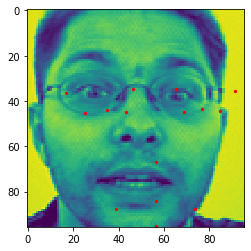

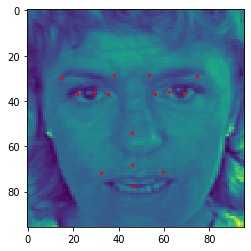

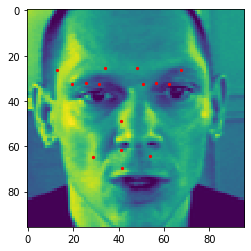

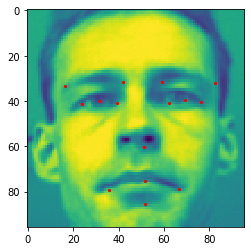

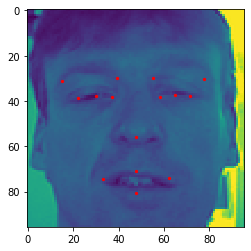

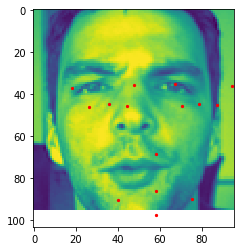

In [0]:
count= 0;
for batch in test_loader:
  predict(batch)
  count += 1
  if count > 5:
    break